# Simple Statistics

or, when in doubt, do a Monte Carlo!

In [70]:
import numpy as np

from scipy.optimize import minimize
# Load plot settings

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from cycler import cycler

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Combining Bins

We will now explore how to combine the errors in bins. We pick 10 Gaussian random variables, eaech with a random mean and variance. We draw 1,000 samples from these 10 random variables, and take the mean, and check if this final distribution agrees with what we expect theoretically: it should go as $N (\sum \mu_i/N, \sum \sigma_i^2/ N^2)$ for $N$ variables. 

In [38]:
N = 10

means_ary = np.random.rand(N)
sigma_ary = np.random.rand(N)


samples = np.array([np.random.normal(means_ary, sigma_ary) for _ in np.arange(10000)])

Text(0.5, 1.0, 'Distribution of the mean')

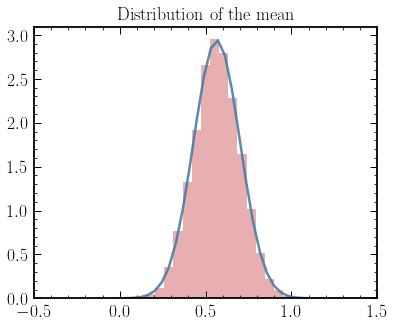

In [42]:
from locale import normalize


plt.figure()

plt.hist(samples.mean(axis=-1), bins=20, density=True, alpha=0.4)

sum_gaussian_mean  = np.sum(means_ary) / N 
sum_gaussian_var   = np.sum(sigma_ary**2) / N**2

x_ary = np.linspace(0, 2, num=50)

plt.plot(x_ary, np.exp(- (x_ary - sum_gaussian_mean)**2 / (2 * sum_gaussian_var)) / np.sqrt(2 * np.pi * sum_gaussian_var) )

plt.xlim(-0.5, 1.5)

plt.title('Distribution of the mean')

## Combining Bins for a Linear Fit

Now we want to see the impact of combining bins on a linear fit. Let's start out with 1,000 Gaussian random variables. We can bin into 10 or 100 bins, and compare. 

In [348]:
N_total = 10000

x_ary = np.linspace(0, 1, num=N_total)

means_ary = x_ary + 3.
# sigma_ary = np.random.rand(N_total) / 5
sigma_ary = np.ones(N_total) / 5

data_ary = np.random.normal(loc=means_ary, scale=sigma_ary)


In [349]:
def binned_data(Nbins): 

    N_per_bin = N_total // N_bins

    means_binned_ary = np.mean(np.reshape(means_ary, (N_bins, N_per_bin)), axis=1)
    data_binned_ary  = np.mean(np.reshape(data_ary,  (N_bins, N_per_bin)), axis=1)
    sigma_binned_ary = np.sqrt(np.sum(np.reshape(sigma_ary**2, (N_bins, N_per_bin)), axis=1) / N_per_bin**2)

    x_binned_ary = np.mean(np.reshape(x_ary, (N_bins, N_per_bin)), axis=1)

    return (x_binned_ary, means_binned_ary, data_binned_ary, sigma_binned_ary)

Number of bins:  20
Max. Likelihood b:  2.9986884462835026
Max. Likelihood p:  1.006042391105922
Max. Likelihood -2 ln L:  14.720789010317795
chi^2/dof:  0.7360394505158897
*************************
Number of bins:  10000
Max. Likelihood b:  2.998237068613015
Max. Likelihood p:  1.006945146446898
Max. Likelihood -2 ln L:  9932.13359238147
chi^2/dof:  0.9932133592381469


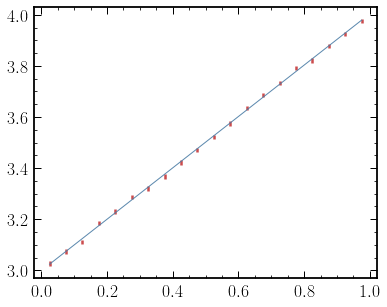

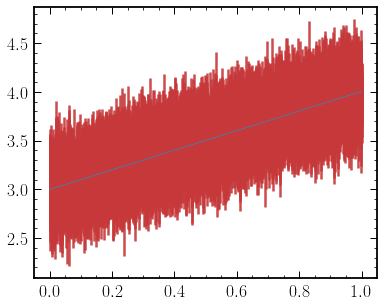

In [350]:
N_bins = 20

x_binned_ary, means_binned_ary, data_binned_ary, sigma_binned_ary = binned_data(N_bins)

b_hat_numer = np.sum(data_binned_ary) * np.sum(x_binned_ary**2) - np.sum(data_binned_ary * x_binned_ary) * np.sum(x_binned_ary)
b_hat_denom = N_bins * np.sum(x_binned_ary**2) - np.sum(x_binned_ary)**2
b_hat = b_hat_numer / b_hat_denom

p_hat = (np.sum(data_binned_ary * x_binned_ary) - b_hat * np.sum(x_binned_ary)) / np.sum(x_binned_ary**2) 

print('Number of bins: ', N_bins)
print('Max. Likelihood b: ', b_hat)
print('Max. Likelihood p: ', p_hat)
print('Max. Likelihood -2 ln L: ', np.sum((data_binned_ary - p_hat*x_binned_ary - b_hat)**2 / sigma_binned_ary**2))
print('chi^2/dof: ', np.sum((data_binned_ary - p_hat*x_binned_ary - b_hat)**2 / sigma_binned_ary**2) / N_bins)

print('*************************')

plt.figure()

plt.errorbar(x_binned_ary, data_binned_ary, sigma_binned_ary, linestyle='')
plt.plot(x_binned_ary, p_hat * x_binned_ary + b_hat, linewidth=1)

N_bins = 10000

x_binned_ary, means_binned_ary, data_binned_ary, sigma_binned_ary = binned_data(N_bins)

b_hat_numer = np.sum(data_binned_ary) * np.sum(x_binned_ary**2) - np.sum(data_binned_ary * x_binned_ary) * np.sum(x_binned_ary)
b_hat_denom = N_bins * np.sum(x_binned_ary**2) - np.sum(x_binned_ary)**2
b_hat = b_hat_numer / b_hat_denom

p_hat = (np.sum(data_binned_ary * x_binned_ary) - b_hat * np.sum(x_binned_ary)) / np.sum(x_binned_ary**2) 

print('Number of bins: ', N_bins)
print('Max. Likelihood b: ', b_hat)
print('Max. Likelihood p: ', p_hat)
print('Max. Likelihood -2 ln L: ', np.sum((data_binned_ary - p_hat*x_binned_ary - b_hat)**2 / sigma_binned_ary**2))
print('chi^2/dof: ', np.sum((data_binned_ary - p_hat*x_binned_ary - b_hat)**2 / sigma_binned_ary**2) / N_bins)

plt.figure()

plt.errorbar(x_binned_ary, data_binned_ary, sigma_binned_ary, linestyle='')
plt.plot(x_binned_ary, p_hat * x_binned_ary + b_hat, linewidth=1)

In [302]:
def log_likelihood(params): 

    p = params[0]
    b = params[1]

    return np.sum((data_binned_ary - p * x_binned_ary - b)**2 / sigma_binned_ary**2) / N_bins

res = minimize(log_likelihood, (1, 3))

print(res)

print(res['fun'] * N_bins)

      fun: 0.9150016032895975
 hess_inv: array([[ 0.77674964, -0.41713168],
       [-0.41713168,  0.22404957]])
      jac: array([-3.33786011e-06,  1.80304050e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([1.00061325, 3.00038914])
18.30003206579195
